# Finding Heavy Traffic Indicators on I-94

[Interstate 94](https://en.wikipedia.org/wiki/Interstate_94) is a Highway spanning roughly 1,555 miles from Montana to Michigan. This project aims to determine indicators of heavy traffic on I-94.

## Dataset
This dataset was created by John Hogue and can be downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

According to the [documentation](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume), this data was collected from a station located roughly midway between Minneapolis andSt Paul, Minnesota that records traffic moving from east to west on I-94. Thus, the results of our analysis will be regarding westbound traffic in proximity to the station and should not be generalized to the entire Highway.

Description of columns:
* `holiday`: US National holidays plus regional holiday
* `temp`: Average temp in kelvin
* `rain_1h`: Amount in mm of rain that occurred in the hour
* `snow_1h`: Amount in mm of snow that occurred in the hour
* `clouds_all`: Percentage of cloud cover
* `weather_main `: Short textual description of the current weather
* `weather_description`: Longer textual description of the current weather
* `date_time`: Hour of the data collected in local CST time
* `traffic_volume`: Hourly I-94 ATR 301 reported westbound traffic volume

In [1]:
import pandas as pd

i_94 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
i_94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
i_94.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
i_94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


This dataset contains 9 columns and 48,204 rows with no null values. Each row corresponds to a specific hour of a day, with most days having all 24 hours recorded. The data covers multiple years, beginning on 2012-10-02 09:00:00 and ending on 2018-09-30 23:00:00.

## Analyzing the Data
Our analysis will predominately be focused on the `traffic_volume` column which measures how many cars passed the station in a given hour.

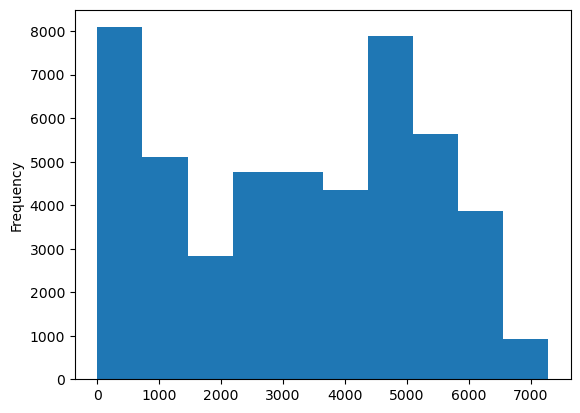

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
i_94['traffic_volume'].plot.hist()
plt.show()

In [5]:
i_94['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

We can see that the traffic volume ranges from 0 to 7280 cars passing the station per hour with an average being 3260 cars.

### Time Indicators
People may drive more during certain times of the day, week, or year.

To examine this, lets first add four new columns to our data (`hour`, `dayofweek`, `month`, `year`) to make working with time more easy.

In [6]:
i_94['date_time'] = pd.to_datetime(i_94['date_time'])
i_94['hour'] = i_94['date_time'].dt.hour
i_94['dayofweek'] = i_94['date_time'].dt.dayofweek
i_94['month'] = i_94['date_time'].dt.month
i_94['year'] = i_94['date_time'].dt.year

#### Day vs. Night
A probable indicator of heavy traffic is daylight, so let's compare daytime and nighttime data.

We'll distinguish them as such:
* Day (7am–7pm)
* Night (7pm–7am)

In [7]:
day = i_94.copy()[(i_94['date_time'].dt.hour >= 7) & (i_94['date_time'].dt.hour < 19)]
print(day.shape)

night = i_94.copy()[(i_94['date_time'].dt.hour >= 19) | (i_94['date_time'].dt.hour < 7)]
print(night.shape)

(23877, 13)
(24327, 13)


The reason the number of rows does not match up is because not everyday had all 24 hours recorded. It appears more hours we're left untracked during the day than at night.

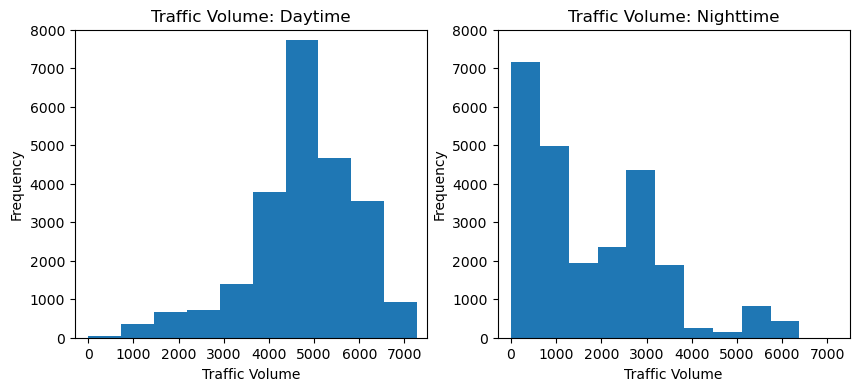

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.xlim(-300, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Daytime')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.xlim(-300, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Nighttime')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()

In [9]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [10]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

The histogram for the daytime traffic volume distribution is left skewed, meaning we see more high traffic volume. The average traffic volume during the day is 4762 cars, with a high of 7280 cars.

The histogram for the nighttime traffic volume distribution is right skewed, meaning we see more low traffic volume. The average traffic volume during the night is 1785 cars, with a high of 6386 cars.

In [11]:
avg_day_vs_night_diff = day['traffic_volume'].mean() - night['traffic_volume'].mean()
print(avg_day_vs_night_diff)

2976.670010818641


That's an average difference of 2,977 cars an hour!

Since our goal is to find indicators of heavy traffic, we'll work with the daytime data for the remainder of this project.

#### Month

People may be more likely to drive during some months compared to others. Let's see if there is a difference.

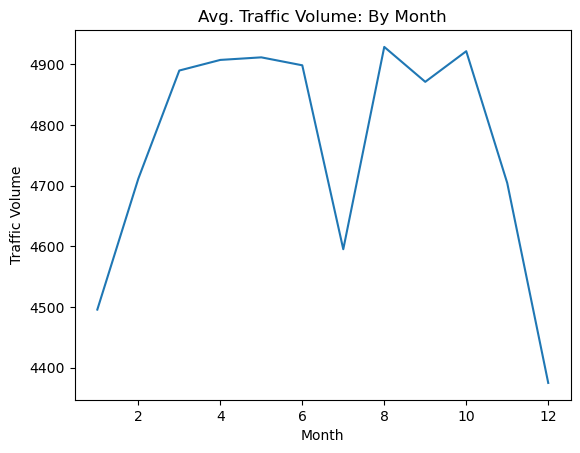

In [12]:
by_month = day.groupby('month')
by_month['traffic_volume'].mean().plot.line()
plt.title('Avg. Traffic Volume: By Month')
plt.xlabel('Month')
plt.ylabel('Traffic Volume')
plt.show()

It appears traffic is slower during the cold months (November–February) and heavier during the warm months (March–October), though with an exception being July.

Let's examine July more closely and see if we can find out why.

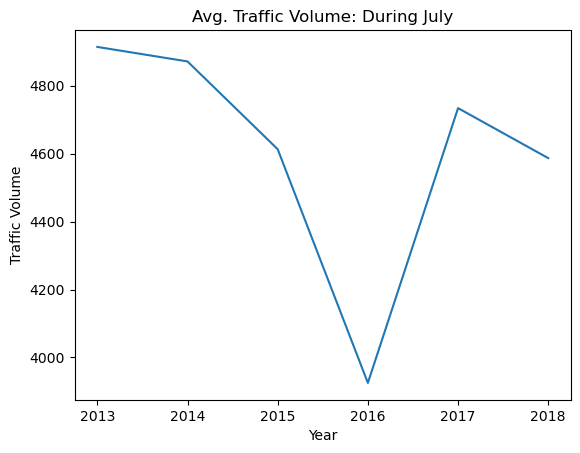

In [13]:
only_july = day[day['month'] == 7]
only_july.groupby('year')['traffic_volume'].mean().plot.line()
plt.title('Avg. Traffic Volume: During July')
plt.xlabel('Year')
plt.ylabel('Traffic Volume')
plt.show()

As we can see, July usually has heavy traffic except for the year 2016. This is possibly due to road construction that was taking place on i-94 that year as seen in [this article from 2016](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696).

Thus, it appears warm months do indicate heavy traffic after all!

Let's see what the average difference is for traffic volume.

In [14]:
warm_months = day.copy()[(day['month'] >= 3)  & (day['month'] <= 10)]
cold_months = day.copy()[(day['month'] <= 2) | (day['month'] >= 11)]
avg_warm_vs_cold_diff = warm_months['traffic_volume'].mean() - cold_months['traffic_volume'].mean()
print(avg_warm_vs_cold_diff)

299.35208254214376


The warmer months have on average 299 more cars an hour passing by the station.

#### Day of the week
Now let's examine how the days of the week affect traffic volume.

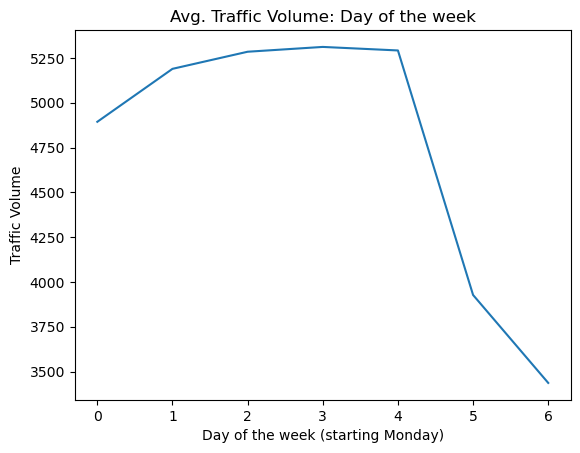

In [15]:
by_dayofweek = day.groupby('dayofweek')
by_dayofweek['traffic_volume'].mean().plot.line()
plt.title('Avg. Traffic Volume: Day of the week')
plt.xlabel('Day of the week (starting Monday)')
plt.ylabel('Traffic Volume')
plt.show()

We can see that traffic is heavier on business days (Monday–Friday) with Sunday's being particularly slow.

Now we're going to measure the difference in traffic volume.

In [16]:
business_days = day.copy()[day['dayofweek'] <= 4] #4 is Friday
weekend = day.copy()[day['dayofweek'] >= 5] #5 is Saturday
avg_business_vs_weekend_diff = business_days['traffic_volume'].mean() - weekend['traffic_volume'].mean()
print(avg_business_vs_weekend_diff)

1509.7590943122673


Business days have on average 1510 more cars on the road each hour.

#### Time of the day
Next, let's see how the time of the day impacts traffic. 

To keep the weekends from affecting the results, we'll examine them seperately from business days.

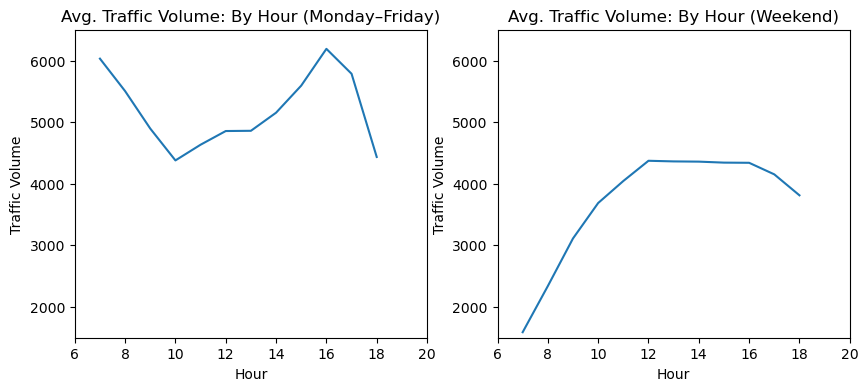

In [17]:
by_hour_business = business_days.groupby('hour')
by_hour_weekend = weekend.groupby('hour')

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].mean().plot.line()
plt.xlim(6, 20)
plt.ylim(1500, 6500)
plt.title('Avg. Traffic Volume: By Hour (Monday–Friday)')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].mean().plot.line()
plt.xlim(6, 20)
plt.ylim(1500, 6500)
plt.title('Avg. Traffic Volume: By Hour (Weekend)')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')

plt.show()

We can see that traffic is busier during most hours of business days compared to weekends. We can also see that rush hour (around 7am and 4pm) causes traffic spikes on business days that are not seen on weekends.

Let's see how much rush hour affects traffic volume.

In [18]:
rush_hour = business_days.copy()[(business_days['hour'] == 7) | (business_days['hour'] == 16)]
other_hours = business_days.copy()[(business_days['hour'] != 7) & (business_days['hour'] != 16)]
avg_rush_vs_other_diff = rush_hour['traffic_volume'].mean() - other_hours['traffic_volume'].mean()
print(avg_rush_vs_other_diff)

1104.3245563802402


Rush hour has on average 1104 more cars an hour on I94.

To summerize what we found traffic is heavier during:
* Daytime (7am–7pm)
* Warm months (March–October).
* Business days (Monday–Friday).
* Rush hour on Business days (around 7am and 4pm).

### Weather Indicators
Bad weather is another likely indicator for heavy traffic.

The following columns relate to weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`.

#### Numeric Weather Columns
Of these columns, the following are numeric: `temp`, `rain_1h`, `snow_1h`, `clouds_all`.

Let's begin by seeing how these four number columns correlate with `traffic_volume`.

In [19]:
day[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

We can see that `temp` (temperature) has the most correlation with a value of +0.128. The other numeric columns (`rain_1h`, `snow_1h`, `clouds_all`) have a negligible correlation, so we will ignore them.

We will now create a scatter plot to see the correlation between `temp` and `traffic_volume`.

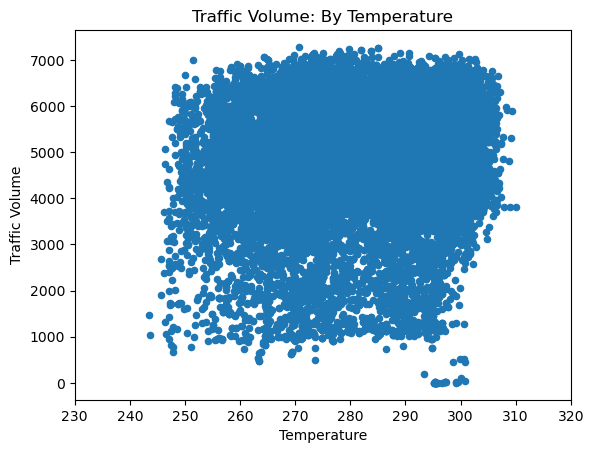

In [20]:
day.plot.scatter('temp', 'traffic_volume')
plt.xlim(230, 320)
plt.title('Traffic Volume: By Temperature')
plt.xlabel('Temperature')
plt.ylabel('Traffic Volume')
plt.show()

It appears temperature is not a strong indicator of heavy traffic.

So, let's now look into the other two weather columns: `weather_main`, `weather_description`.

#### Weather Types
We will begin by grouping the values in `weather_main` and examining the averages for `traffic_volumes`.

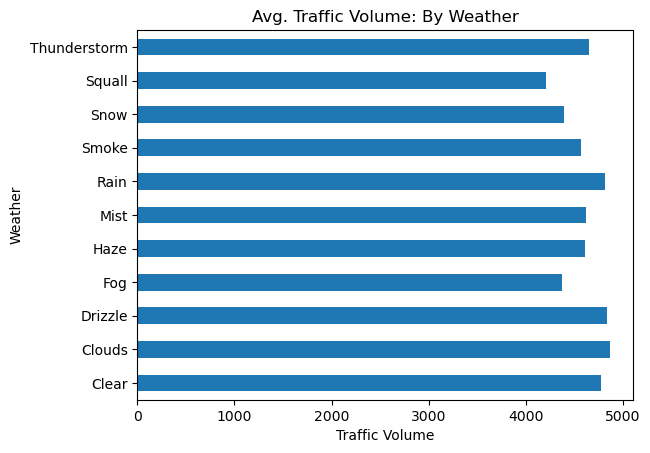

In [21]:
by_weather_main = day.groupby('weather_main')
by_weather_main['traffic_volume'].mean().plot.barh()
plt.title('Avg. Traffic Volume: By Weather')
plt.xlabel('Traffic Volume')
plt.ylabel('Weather')
plt.show()

It appears this column does not provide any outliers in the data. So, let's examine `weather_description` and see if that column gives us more to go on.

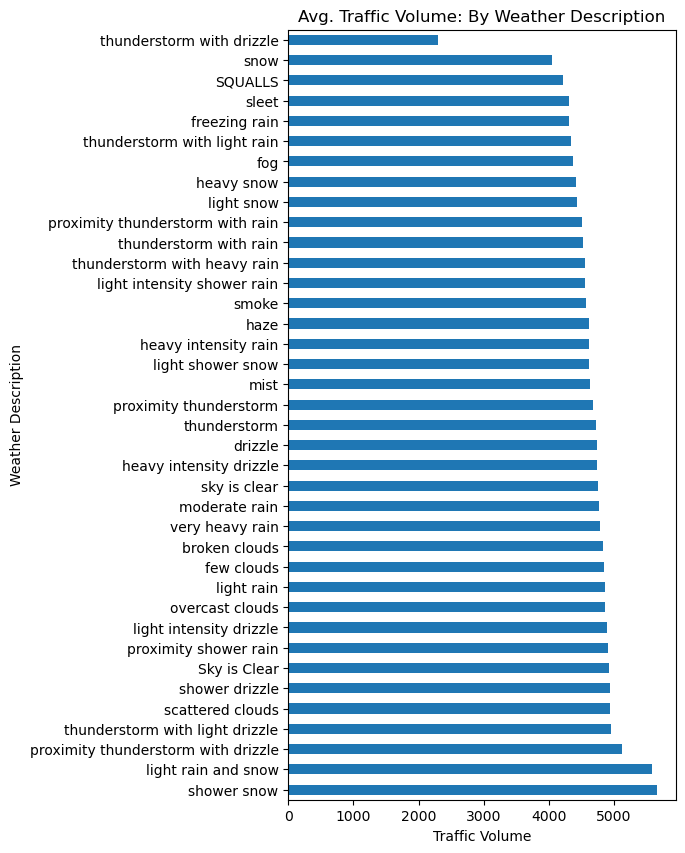

In [22]:
by_weather_description = day.groupby('weather_description')
by_weather_description_mean = by_weather_description['traffic_volume'].mean().sort_values(ascending=False)
by_weather_description_mean.plot.barh(figsize=(5, 10))
plt.title('Avg. Traffic Volume: By Weather Description')
plt.xlabel('Traffic Volume')
plt.ylabel('Weather Description')
plt.show()

Much better!

We can see there are three types of weather that cause traffic volume to exceed 5,000 cars:
* Shower snow
* Light rain and snow
* Proximity thuderstrom with drizzle

## Conclusion
In this project, we aimed to find indicators of heavy traffic on the Interstate 94 Highway.

We found the largest indicators of heavy traffic to be:
* Daylight (7am–7pm) – 2,977 more cars an hour on average compared to nighttime.
* Business days (Monday–Friday) – 1510 more cars an hour on average compared to the weekend.
* Rush hour (7am & 4pm) – 1104 more cars an hour on average compared to other daylight hours on buisness days.
* Warm months (March–October) – 299 more cars an hour on average compared to cold months.

We also found weather to be a lesser indicator of heavy traffic. Largest weather factors were:
* Shower snow
* Light rain and snow
* Proximity thunderstorm with drizzle